# Milestone Project 2: SkimLit

### General Information

In this project, we're going to be replicating the deep learning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/pdf/1710.06071.pdf).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?


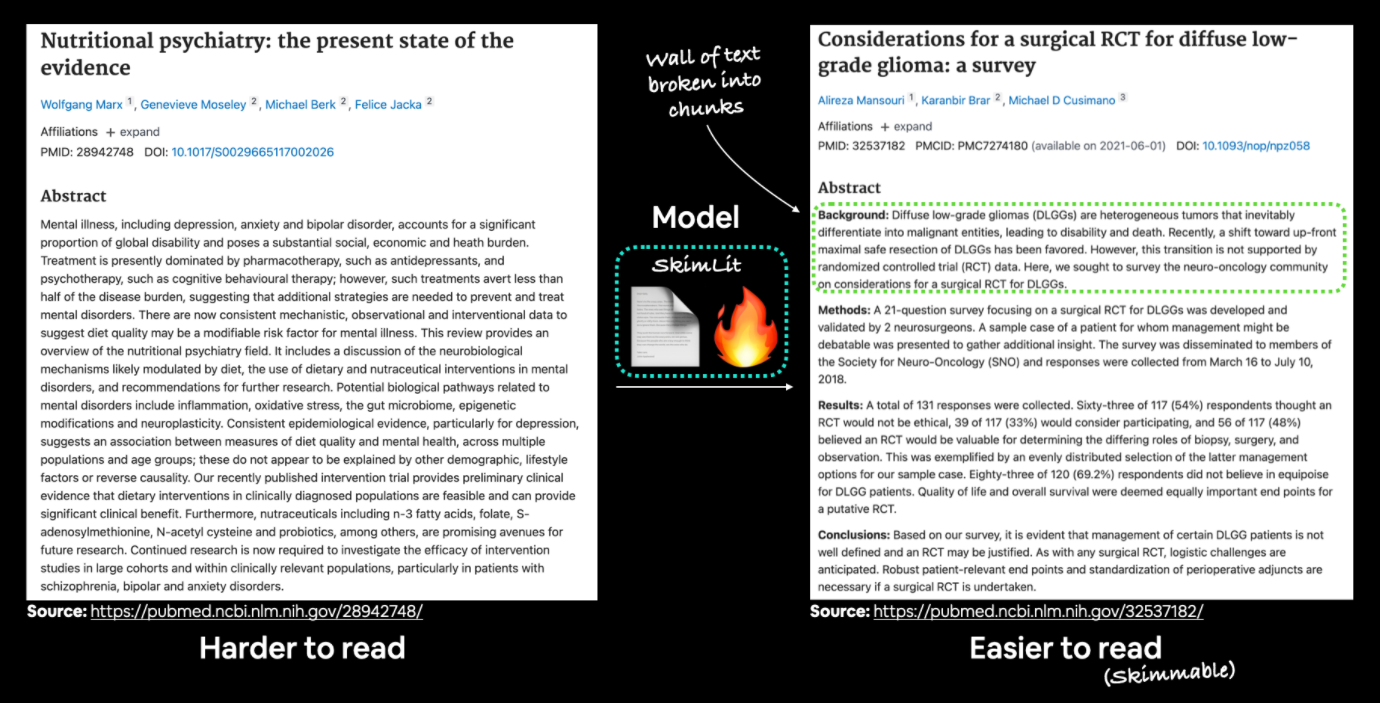

**Problem in a sentence**

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

**Solution in a sentence**

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

Where our data is coming from: [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/pdf/1710.06071.pdf)


---


Where our model is coming from: [Neural networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### Confirm acces to a GPU

In [ ]:
!nvidia-smi

Sat Oct  2 07:17:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Get data

Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

We strat with PubMed_20K first, and then scale up to PubMed_200K.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Beautiful, looks like we've got three separate text files:

* `train.txt` - training samples.
* `dev.txt` - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* `test.txt` - test samples.

In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preparing data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

We can't use the data as it is, we need to preprocess it first.

Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 393 ms, sys: 95.8 ms, total: 489 ms
Wall time: 491 ms


In [ ]:
# check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

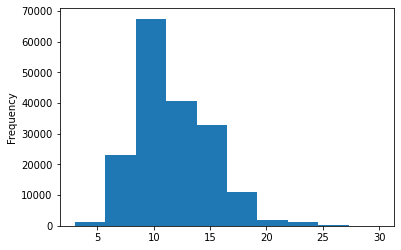

In [ ]:
# length of different lines
train_df.total_lines.plot.hist()

In [ ]:
# convert text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# make numeric labels (one-hot-encode)
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

In [ ]:
# label encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
# get class names and number of classes from labelencoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0: Getting a baseline

Our first model we'll be a TF-IDF Multinomial Naive Bayes

In [ ]:
# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Nice! Looks like 72.1% accuracy will be the number to beat with our deeper models.

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing our data for deep sequence models

In [ ]:
# how long is each sentence on aberage
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

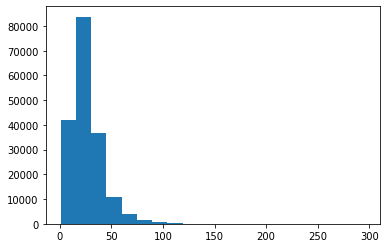

In [ ]:
# whats the distribution look like?
plt.hist(sent_lens, bins=20);

According to the histogram, the vast majority of sentences consists of 50 or less words

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# maximum seq lenght
max(sent_lens)

296

In [ ]:
# How many words are in our vocabulary? 
# (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

Great! Looks like our text_vectorizer is ready, let's adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# test out text vectorizer on random sentence
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
plasma noradrenalin concentration increased significantly ( p < @ ) during exercise in the glucose trial , but not in the hbcd trial .

Length of text: 24

Vectorized text:
[[  249 36282   422    96    39    14    52   177     5     2   268    32
     72    31     5     2 31022    32     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# how many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [ ]:
# create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True, # if you have a lot of zeros in data
                               name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
plasma noradrenalin concentration increased significantly ( p < @ ) during exercise in the glucose trial , but not in the hbcd trial .

Sentence after vectorization (before embedding):
[[  249 36282   422    96    39    14    52   177     5     2   268    32
     72    31     5     2 31022    32     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04218023  0.0463015   0.02865082 ... -0.02584468  0.03269008
   -0.01097472]
  [-0.04032645 -0.00179266  0.02067916 ...  0.02160939 -0.00746763
   -0.02759489]
  [-0.04622917 -0.03632814 -0.02975702 ... -0.02228377 -0.045304
    0.03031869]
  ...
  [ 0.00113223 -0.01225194  0.00024018 ... -0.02762647 -0.03554315
    0.00171063]
  [ 0.00113223 -0.01225194  0.00024018 ... -0.02762647 -0.03554315
    0.001710

### Create datasets (making sure our data loads as fast as possible)

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

In [ ]:
# turn our data into TS Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# turn into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings

In [ ]:
# create 1D Conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1D")

# compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
__________________________________________

In [ ]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(.25*len(train_dataset)),
                              epochs=6,
                              validation_data=valid_dataset,
                              validation_steps=int(.1*len(valid_dataset))
                              )

Epoch 1/6
1406/1406 [==============================] - 25s 5ms/step - loss: 0.7574 - accuracy: 0.7087 - val_loss: 0.6102 - val_accuracy: 0.7773
Epoch 2/6
1406/1406 [==============================] - 8s 5ms/step - loss: 0.5960 - accuracy: 0.7868 - val_loss: 0.5592 - val_accuracy: 0.7939
Epoch 3/6
1406/1406 [==============================] - 8s 5ms/step - loss: 0.5633 - accuracy: 0.7992 - val_loss: 0.5382 - val_accuracy: 0.8072
Epoch 4/6
1406/1406 [==============================] - 8s 5ms/step - loss: 0.5425 - accuracy: 0.8087 - val_loss: 0.5354 - val_accuracy: 0.8022
Epoch 5/6
1406/1406 [==============================] - 0s 186us/step - loss: 0.6752 - accuracy: 0.7917 - val_loss: 0.5397 - val_accuracy: 0.8029


In [ ]:
# evaluate on whole data
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5328 - accuracy: 0.8105


[0.5328400135040283, 0.810505747795105]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)

In [ ]:
# convert to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)

model_1_results

{'accuracy': 81.050575930094,
 'f1': 0.8068711521503779,
 'precision': 0.8083084118441385,
 'recall': 0.81050575930094}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Model 2: Feature extraction with pretrained token embeddings

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)

Note: there is no tokenization layer in the workflow as in our previous Conv1D model. This is because USE takes care of tokenization by itself.

In [ ]:
# create keras layer using USE pretrained layer from Tensor Hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = sentence_encoder_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
we expect prepare interventions to have an impact on hypothesized determinants of risky sexual behaviour and in western cape and dar es salaam to change sexual practices .

Sentence after embedding:
[-0.02579329  0.02898083  0.02860604 -0.06491995 -0.01753912  0.03741627
  0.0103487  -0.02122476  0.03895524  0.00119728 -0.01935894  0.05832867
 -0.00204417  0.07681463  0.07245366 -0.06717825 -0.03853419 -0.01165388
  0.04389631 -0.03659815  0.07552982  0.01147847 -0.0289252  -0.02553401
 -0.02778771 -0.03193504  0.00551969 -0.06233467  0.00858076  0.0453435 ] (truncated output)...

Length of sentence embedding:
512


In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = sentence_encoder_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Checking the summary of our model we can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set `training=False` when we instatiated our USE feature extractor layer.

So when we train our model, only the top two output layers will be trained.

In [ ]:
# Fit feature extractor model for 5 epochs
history_model_2 = model_2.fit(train_dataset,
                  steps_per_epoch=int(0.1 * len(train_dataset)),
                  epochs=5,
                  validation_data=valid_dataset,
                  validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 8s 11ms/step - loss: 0.9157 - accuracy: 0.6496 - val_loss: 0.7964 - val_accuracy: 0.6902
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7689 - accuracy: 0.7021 - val_loss: 0.7536 - val_accuracy: 0.7045
Epoch 3/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7532 - accuracy: 0.7120 - val_loss: 0.7404 - val_accuracy: 0.7108
Epoch 4/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7207 - accuracy: 0.7236 - val_loss: 0.7132 - val_accuracy: 0.7271
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7296 - accuracy: 0.7194 - val_loss: 0.6938 - val_accuracy: 0.7344


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7014 - accuracy: 0.7339


[0.7014194130897522, 0.7339468002319336]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[6.4037341e-01, 2.1206471e-01, 2.9722075e-03, 1.3334851e-01,
        1.1241110e-02],
       [4.5762610e-01, 4.2720190e-01, 4.4937395e-03, 1.0799624e-01,
        2.6820921e-03],
       [4.1576275e-01, 7.1544975e-02, 4.6059310e-02, 4.2107525e-01,
        4.5557648e-02],
       ...,
       [1.7173833e-03, 1.8942794e-03, 1.1456304e-01, 5.3751335e-04,
        8.8128775e-01],
       [2.2104643e-03, 2.4619175e-02, 4.8502091e-01, 9.6647179e-04,
        4.8718303e-01],
       [1.7133634e-01, 3.4164762e-01, 4.5498842e-01, 2.5863610e-03,
        2.9441139e-02]], dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.39467761154508,
 'f1': 0.7281551864889609,
 'precision': 0.7303531958604133,
 'recall': 0.7339467761154508}

### Model 3: Conv1D with character embeddings

#### Creating a character-level tokenizer

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. `hello -> [h, e, l, l, o]`) where as a token embedding is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the `TextVectorization` class and then passing those vectorized sequences through an Embedding layer.

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# make function to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
split_chars(random_training_sentence)

'w e   e x p e c t   p r e p a r e   i n t e r v e n t i o n s   t o   h a v e   a n   i m p a c t   o n   h y p o t h e s i z e d   d e t e r m i n a n t s   o f   r i s k y   s e x u a l   b e h a v i o u r   a n d   i n   w e s t e r n   c a p e   a n d   d a r   e s   s a l a a m   t o   c h a n g e   s e x u a l   p r a c t i c e s   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# what's the average character length ?
char_lens = [len(sentence) for sentence in train_sentences]
np.mean(char_lens)

149.3662574983337

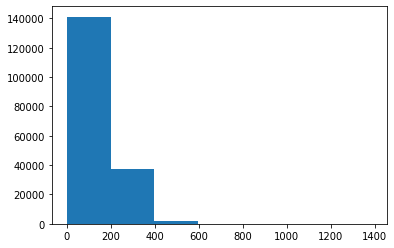

In [ ]:
plt.hist(char_lens, bins=7);

In [ ]:
# find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [ ]:
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # include punctuation
                                    name='char_vectorizer')

In [ ]:
# adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
r e s t a g i n g   u s i n g   c t   a f t e r   n e o a d j u v a n t   c h e m o t h e r a p y   f o r   g a s t r i c   c a n c e r   i s   c o n s i d e r e d   t o   b e   i n a c c u r a t e   a n d   u n r e l i a b l e   .

Length of chars: 100

Vectorized chars:
[[ 8  2  9  3  5 18  4  6 18 16  9  4  6 18 11  3  5 17  3  2  8  6  2  7
   5 10 27 16 21  5  6  3 11 13  2 15  7  3 13  2  8  5 14 19 17  7  8 18
   5  9  3  8  4 11 11  5  6 11  2  8  4  9 11  7  6  9  4 10  2  8  2 10
   3  7 22  2  4  6  5 11 11 16  8  5  3  2  5  6 10 16  6  8  2 12  4  5
  22 12  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  

You'll notice sequences with a length shorter than 290 (`output_seq_char_length`) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the standardize parameter of TextVectorization being `"lower_and_strip_punctuation"` and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.

#### Creating a character-level embedding

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name='char_embed')

In [ ]:
# test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
r e s t a g i n g   u s i n g   c t   a f t e r   n e o a d j u v a n t   c h e m o t h e r a p y   f o r   g a s t r i c   c a n c e r   i s   c o n s i d e r e d   t o   b e   i n a c c u r a t e   a n d   u n r e l i a b l e   .

Embedded chars (after vectorization and embedding):
[[[-0.03523894  0.0325366  -0.01105295 ... -0.0255383  -0.03701578
   -0.01096771]
  [-0.00503691 -0.04132802  0.0272071  ...  0.01979545 -0.03568909
    0.00384136]
  [-0.0364318   0.01787796 -0.01235925 ... -0.03656912  0.01866773
   -0.01948312]
  ...
  [-0.0181048   0.01646299  0.03654421 ...  0.0123613  -0.04185114
    0.03672668]
  [-0.0181048   0.01646299  0.03654421 ...  0.0123613  -0.04185114
    0.03672668]
  [-0.0181048   0.01646299  0.03654421 ...  0.0123613  -0.04185114
    0.03672668]]]

Character embedding shape: (1, 290, 25)


Wonderful! Each of the characters in our sequences gets turned into a 25 dimension embedding.

#### Building a Conv1D model to fit on character embeddings

In [ ]:
# create 1D Conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs) # vectorize text inputs
char_embeddings = char_embed(char_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D")

# compile
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3.summary()

Model: "model_3_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________________________

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# fit the model
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(.1*len(train_char_dataset)),
                              epochs=6,
                              validation_data=val_char_dataset,
                              validation_steps=int(.1*len(val_char_dataset))
                              )

Epoch 1/6
562/562 [==============================] - 3s 5ms/step - loss: 1.2673 - accuracy: 0.4885 - val_loss: 1.0573 - val_accuracy: 0.5938
Epoch 2/6
562/562 [==============================] - 3s 5ms/step - loss: 1.0097 - accuracy: 0.5988 - val_loss: 0.9368 - val_accuracy: 0.6486
Epoch 3/6
562/562 [==============================] - 3s 5ms/step - loss: 0.9170 - accuracy: 0.6380 - val_loss: 0.8686 - val_accuracy: 0.6692
Epoch 4/6
562/562 [==============================] - 3s 5ms/step - loss: 0.8687 - accuracy: 0.6643 - val_loss: 0.8383 - val_accuracy: 0.6749
Epoch 5/6
562/562 [==============================] - 3s 5ms/step - loss: 0.8492 - accuracy: 0.6711 - val_loss: 0.8146 - val_accuracy: 0.6848
Epoch 6/6
562/562 [==============================] - 3s 5ms/step - loss: 0.8331 - accuracy: 0.6780 - val_loss: 0.7878 - val_accuracy: 0.6951


In [ ]:
# evaluate on whole data
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7942 - accuracy: 0.6978


[0.7941988706588745, 0.6977691054344177]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.11190336, 0.61989033, 0.08389717, 0.1324508 , 0.05185835],
       [0.37347102, 0.30920383, 0.02466479, 0.26461112, 0.02804917],
       [0.169279  , 0.3031688 , 0.07637935, 0.41656047, 0.03461235],
       ...,
       [0.03024073, 0.06511462, 0.06301441, 0.03514734, 0.8064829 ],
       [0.01540524, 0.07685171, 0.4493686 , 0.01834534, 0.44002917],
       [0.3307866 , 0.36364648, 0.27190578, 0.02779276, 0.00586837]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 2, 1])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 69.7769098371508,
 'f1': 0.6900666984836715,
 'precision': 0.6876476891208868,
 'recall': 0.697769098371508}

### Model 4: Combining pretrained token embeddings with characters embeddings

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural 5. 5. Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = sentence_encoder_layer(token_inputs) # pretrained embedding layer
# text_vectors = text_vectorizer(token_inputs)
# token_embeddings = token_embed(text_vectors) # custom embedding layer
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. setup char inputs/model
char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. concatenate token and char inputs
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. create output layers - adding in dropouts
combined_dropout = layers.Dropout(.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
# get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

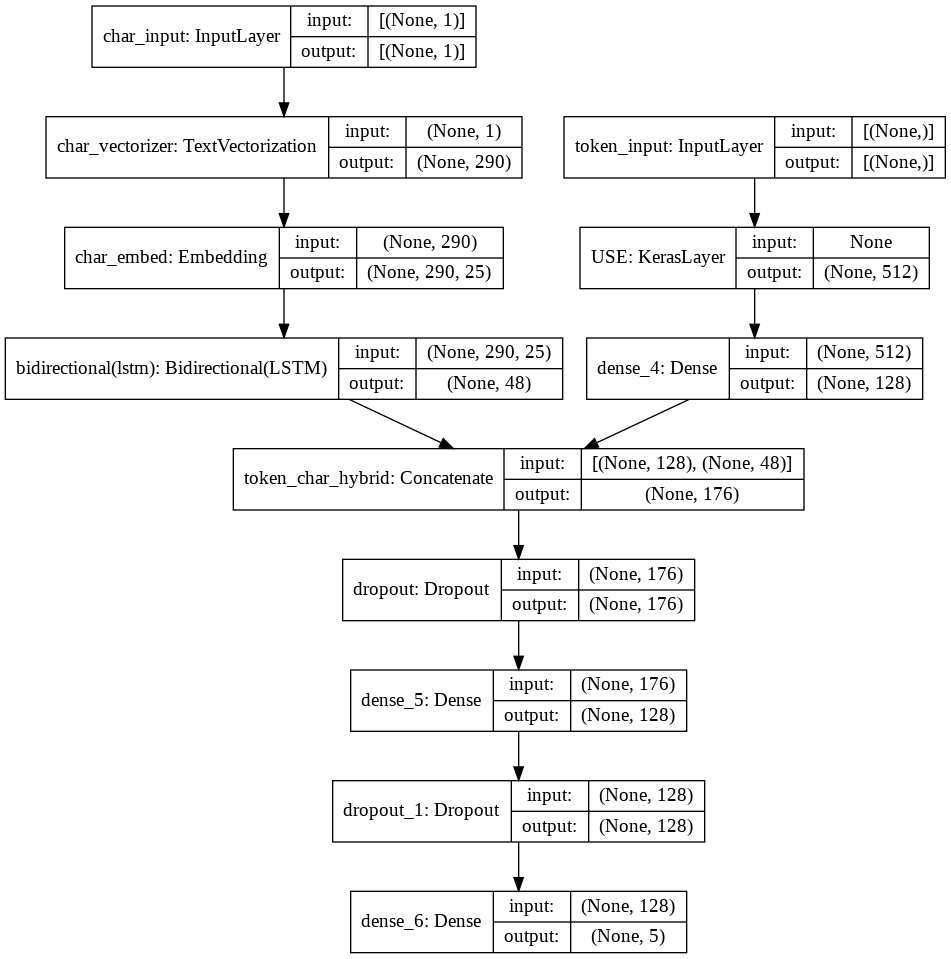

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

And again, to keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:

`((token_data, char_data), (label))`

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# fit the model
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(.1*len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 34s 47ms/step - loss: 0.9808 - accuracy: 0.6088 - val_loss: 0.7782 - val_accuracy: 0.6978
Epoch 2/5
562/562 [==============================] - 24s 43ms/step - loss: 0.8031 - accuracy: 0.6870 - val_loss: 0.7165 - val_accuracy: 0.7307
Epoch 3/5
562/562 [==============================] - 22s 39ms/step - loss: 0.7766 - accuracy: 0.7042 - val_loss: 0.6891 - val_accuracy: 0.7414
Epoch 4/5
562/562 [==============================] - 25s 45ms/step - loss: 0.7434 - accuracy: 0.7209 - val_loss: 0.6615 - val_accuracy: 0.7527
Epoch 5/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7489 - accuracy: 0.7142 - val_loss: 0.6495 - val_accuracy: 0.7557


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6604 - accuracy: 0.7477


[0.6604331731796265, 0.747683048248291]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.76830398517146,
 'f1': 0.7420884142446987,
 'precision': 0.743684129005567,
 'recall': 0.7476830398517146}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

#### Create positional embeddings

In [ ]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

To figure out what we should set the `depth` parameter to, let's investigate the distribution of the `"line_number"` column.

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

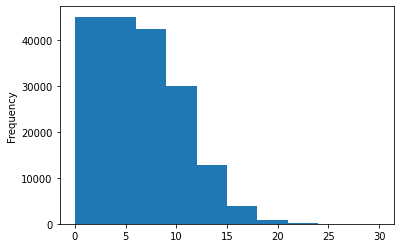

In [ ]:
# check the disctribution of 'line number' column
train_df.line_number.plot.hist();

It seems that the majority of values in `line_number` lies within the range 0 to 16.

In [ ]:
# use TF to create one-hot encoded tensors of our line_number column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=16)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 16), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=16)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=16)

Now, let's one-hot-encode `total_lines` feature.

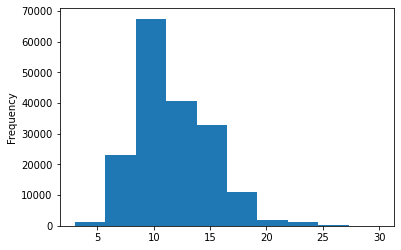

In [ ]:
# check the distribution
train_df['total_lines'].plot.hist();

In [ ]:
# check the coverage of a 'total_lines' values of 20
np.percentile(train_df.total_lines, 99)

21.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=21)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=21)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=21)

#### Building a tribrid embedding model

It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Create a `"line_number"` model (takes in one-hot-encoded `"line_number"` tensor and passes it through a non-linear layer)
4. Create a `"total_lines"` model (takes in one-hot-encoded `"total_lines"` tensor and passes it through a non-linear layer)
5. Combine (using `layers.Concatenate`) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output
6. Combine (using `layers.Concatenate`) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`

In [ ]:
# 1. token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. char inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. line numbers inputs
line_number_inputs = layers.Input(shape=(16,), dtype=tf.int32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. total lines inputs
total_lines_inputs = layers.Input(shape=(21,), dtype=tf.int32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='token_char_hybrid_embedding')([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(.5)(z)

# 6. combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(z)

# 8. put together model
model_5 = tf.keras.Model(inputs=[line_number_model.inputs,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
# get summary 
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________________________

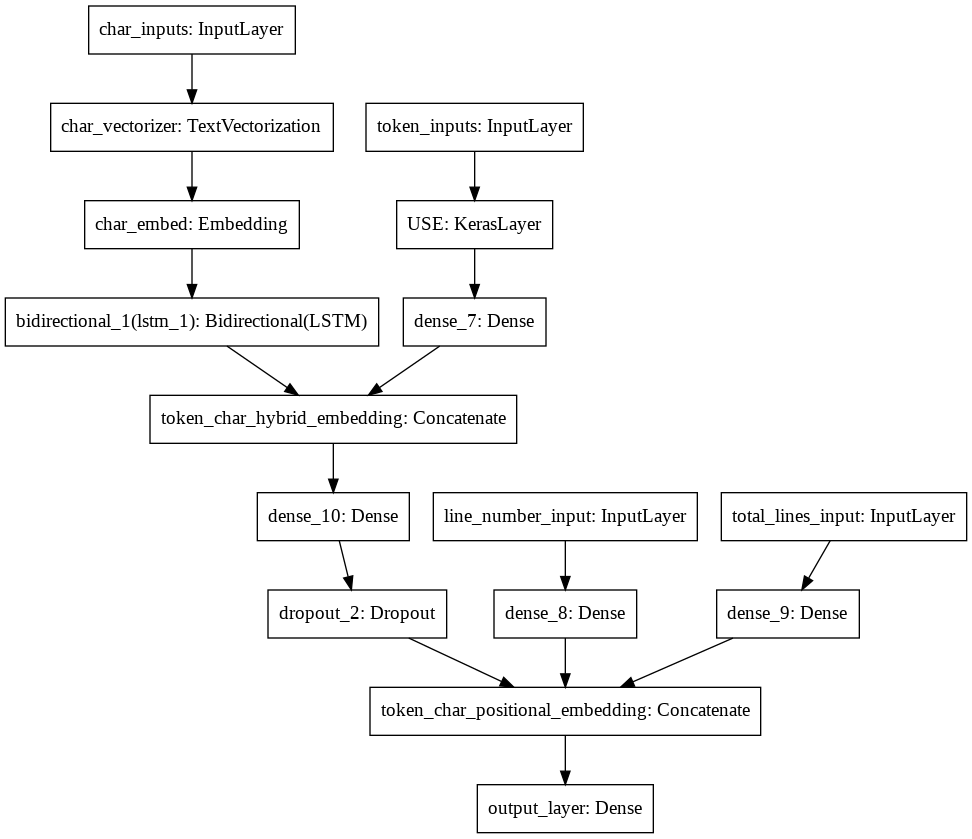

In [ ]:
plot_model(model_5)

In [ ]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f399e6c4350> True
<keras.engine.input_layer.InputLayer object at 0x7f399e652b10> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f39b3472350> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f3a96505610> False
<keras.layers.embeddings.Embedding object at 0x7f39b33c7c50> True
<keras.layers.core.Dense object at 0x7f399e6622d0> True
<keras.layers.wrappers.Bidirectional object at 0x7f399e5d8450> True
<keras.layers.merge.Concatenate object at 0x7f398f3a1c10> True
<keras.engine.input_layer.InputLayer object at 0x7f398f314550> True
<keras.engine.input_layer.InputLayer object at 0x7f399e5d1610> True
<keras.layers.core.Dense object at 0x7f398f147550> True
<keras.layers.core.Dense object at 0x7f3a7f0f9ad0> True
<keras.layers.core.Dense object at 0x7f3a967783d0> True
<keras.layers.core.Dropout object at 0x7f398f1489d0> True
<keras.layers.merge.Concatenate object at 0x7f3a7f0f19d0> True
<keras.layers.core.

Now our model is constructed, let's compile it.

This time, we're going to introduce a new parameter to our loss function called `label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

More Info: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# compile the tribrid model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

This time our model requires four feature inputs:

1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched PrefetchedDataset's.

In [ ]:
# create training & validation datasets (all four kinds of inputs)
# train dataset
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset



(<PrefetchDataset shapes: (((None, 16), (None, 21), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 16), (None, 21), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# fit the tribrid model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(.1*len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(.1*len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 48ms/step - loss: 1.0974 - accuracy: 0.7260 - val_loss: 0.9804 - val_accuracy: 0.8039
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9657 - accuracy: 0.8141 - val_loss: 0.9478 - val_accuracy: 0.8258
Epoch 3/3
562/562 [==============================] - 22s 40ms/step - loss: 0.9487 - accuracy: 0.8235 - val_loss: 0.9390 - val_accuracy: 0.8334


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 20s 19ms/step


array([[0.5062452 , 0.09163124, 0.00665672, 0.38543475, 0.01003214],
       [0.55259496, 0.10430343, 0.03636288, 0.29738012, 0.00935864],
       [0.3165042 , 0.09517517, 0.12032899, 0.39675444, 0.07123721],
       ...,
       [0.03722316, 0.10536493, 0.04395197, 0.03022642, 0.7832335 ],
       [0.03398173, 0.27020264, 0.08446056, 0.02560531, 0.5857498 ],
       [0.19153087, 0.5741987 , 0.11424533, 0.05259231, 0.0674328 ]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.3443664768966,
 'f1': 0.832367713014648,
 'precision': 0.8324548926167247,
 'recall': 0.8334436647689659}

### Compare model results

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,81.050576,0.808308,0.810506,0.806871
pretrained_token_embed,73.394678,0.730353,0.733947,0.728155
custom_char_embed_conv1d,69.776910,0.687648,0.697769,0.690067
hybrid_char_token_embed,74.768304,0.743684,0.747683,0.742088
tribrid_pos_char_token_embed,83.344366,0.832455,0.833444,0.832368


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

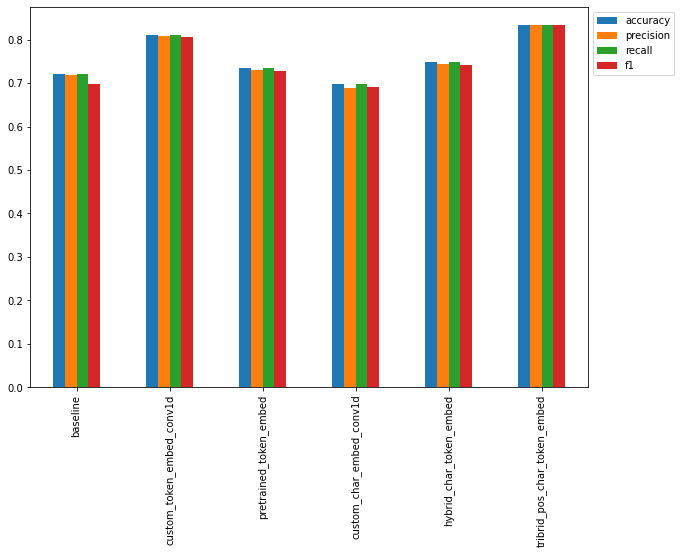

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

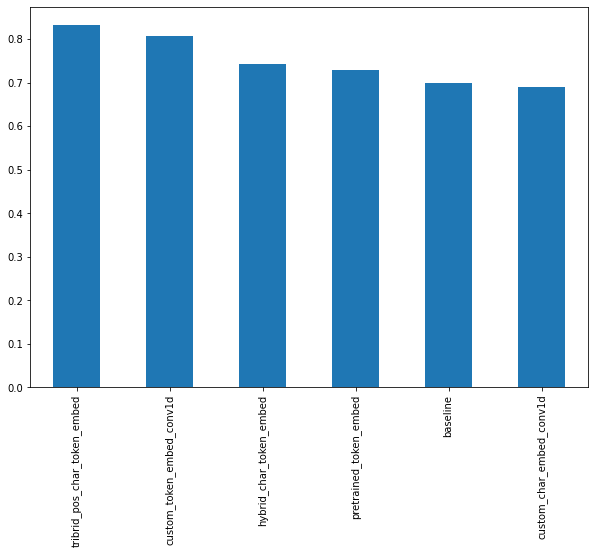

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Based on F1-scores, it looks like our **tribrid embedding model** performs the best by a fair margin.

### Save and load best performing model

Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain it.

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save('skimlit_tribrid_model') # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


When loading in our model, since it uses a couple of custom objects (our TensorFlow Hub layer and `TextVectorization` layer), we'll have to load it in by specifying them in the `custom_objects` parameter of `tf.keras.models.load_model()`.

### Evaluate model on test dataset

In [ ]:
# create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 16), (None, 21), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
# make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset, verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 18s 19ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
# Evaluate loaded model test predictions
model_5_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
model_5_test_results

{'accuracy': 82.9500580720093,
 'f1': 0.8283619323935525,
 'precision': 0.8281547736425118,
 'recall': 0.8295005807200929}

### Find most wrong predictions

One of the best ways to investigate where your model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 10.4 s, sys: 906 ms, total: 11.3 s
Wall time: 9.6 s


In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.445188,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.336502,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.766843,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.684750,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.750744,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.888259,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.469863,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.497791,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.451971,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.566560,True


In [ ]:
# Find top 20 most wrong samples
top_20_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:20]
top_20_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.948415,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,19,19,BACKGROUND,0.946995,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.946578,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.941748,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934961,False
17399,METHODS,clinicaltrials.gov identifier : nct@ .,4,9,BACKGROUND,0.933894,False
26912,CONCLUSIONS,( clinicaltrials.gov : nct@ ) .,13,13,BACKGROUND,0.924734,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.920722,False
29692,RESULTS,repeated measures analysis of variance ( anova...,3,6,METHODS,0.911801,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.911667,False


In [ ]:
# Investigate top wrong preds
for row in top_20_wrong[0:6].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9484152793884277, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9469953775405884, Line number: 19, Total lines: 19

Text:
clinicaltrials.gov identifier : nct@ .

-----

Target: RESULTS, Pred: BACKGROUND, Prob: 0.9465783834457397, Line number: 8, Total lines: 15

Text:
non-diffuse-trickling '' ) .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9417484998703003, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9349608421325684, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9338940382003784, Line number: 4, Total lines: 9

Text:
clinicaltrials.gov identifier : nct@ .

-----



What do we notice about the most wrong predictions? Does the model make silly mistakes? Or are some of the labels incorrect/ambiguous (e.g. a line in an abstract could potentially be labelled OBJECTIVE or BACKGROUND and make sense).

A next step here would be if there are a fair few samples with inconsistent labels, we could go through our training dataset, update the labels and then retrain a model. The process of using a model to help improve/investigate our dataset's labels is often referred to as **active learning**.

* train on the whole data for more than 3 epochs
* use callbacks (Checkpoint & EarlyStopping)
* try both custom & pretrained embeddings (in a tribrid model)
* try lemmatization & stopwords before tokenization